# Stage D: Advanced Models + Imbalance Handling (CV Only)

## 1️⃣ 개요

본 노트북은 **Stage C의 베이스라인 대비 고급 트리 기반 모델**을 활용하여 불량 탐지 성능을 개선하는 것을 목표로 합니다.

### 핵심 차별점
- **CV Only 전략**: Holdout Test Set 없이 5-Fold Cross-Validation만으로 평가
- **스케일러 제거**: 트리 기반 모델은 스케일에 둔감하므로 전처리 단순화
- **고급 모델 활용**: RandomForest, XGBoost, LightGBM, CatBoost
- **일관된 실험 설계**: Stage C와 동일한 피처/샘플링 기법 사용으로 공정 비교

---

## 2️⃣ 실험 설계

| 항목 | 내용 |
|------|------|
| **입력 데이터** | `data/processed/base_master_median.parquet` |
| **피처 세트** | `core_features_top40.json` (Stability Selection 결과) |
| **타깃 변수** | label (0 = 정상, 1 = 불량) |
| **검증 전략** | StratifiedKFold(n_splits=5, shuffle=True, random_state=42) |
| **전처리** | ❌ 스케일러 제거 (트리 계열은 스케일 불필요) |
| **불균형 처리** | SMOTE / SMOTE+TomekLinks / RandomUnderSampler |
| **모델 후보** | RandomForest / XGBoost / LightGBM / CatBoost |
| **평가 지표** | **AUC-PR** (1차) → Recall → F1 → ROC-AUC |

---

## 3️⃣ 실험 조합

- **총 12개 조합**: 3개 샘플링 기법 × 4개 고급 모델
- **각 조합마다 5-Fold CV 수행** → 평균 및 표준편차 산출
- **지표 우선순위**: AUC-PR → Recall → F1 (불량 탐지율 중심 평가)

---

## 4️⃣ 산출물

1. **CV 성능 테이블**: `results/stageD/cv_metrics_summary.csv`
   - 12개 조합별 AUC-PR, Recall, F1, ROC-AUC의 평균 ± 표준편차

2. **최고 성능 모델 저장**: `models/best_advanced_model_cv.pkl`
   - AUC-PR 기준 최고 성능 조합의 마지막 fold 모델

3. **시각화 자료**: `results/stageD/figures/`
   - 조합별 성능 비교 막대 그래프
   - 샘플링/모델별 평균 성능 히트맵

4. **상세 로그**: `results/stageD/detailed_cv_results.json`
   - 모든 fold별 세부 지표 기록

---

## 5️⃣ Stage C vs Stage D 비교

| 구분 | Stage C (Baseline) | Stage D (Advanced - CV) |
|------|-------------------|-------------------------|
| **검증 방식** | Train/Test Split (80:20) | 5-Fold Cross-Validation |
| **스케일링** | RobustScaler 적용 | ❌ 제거 |
| **모델** | LR, SVM, DT (기본) | RF, XGB, LGBM, CatBoost (고급) |
| **조합 수** | 9개 (3×3) | 12개 (3×4) |
| **1차 지표** | Recall | AUC-PR |
| **산출물** | 단일 모델 + 메트릭 | CV 평균±표준편차 |

---

In [17]:
# ============================================================
# 🧩 Stage D 환경 세팅 (고급 모델 + CV Only)
# ============================================================

import numpy as np
import pandas as pd
import json, pickle
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ---------------- CV 전략 ----------------
from sklearn.model_selection import StratifiedKFold

# ---------------- 불균형 처리 ----------------
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# ---------------- 고급 트리 기반 모델 ----------------
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ---------------- 평가 지표 ----------------
from sklearn.metrics import (
    recall_score, precision_score, f1_score, 
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

# ---------------- 시각화 ----------------
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📂 경로 설정
# ============================================================
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

DATA_MASTER = ROOT / 'data' / 'processed' / 'base_master_median.parquet'
CORE_FEATURES_PATH = ROOT / 'results' / 'stageC' / 'core_features_top40.json'

DIR_RESULTS = ROOT / 'results' / 'stageD'
DIR_MODELS  = ROOT / 'models'
DIR_FIGURES = DIR_RESULTS / 'figures'

for d in [DIR_RESULTS, DIR_MODELS, DIR_FIGURES]:
    d.mkdir(parents=True, exist_ok=True)

# ============================================================
# ⚙️ 재현성
# ============================================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================
# 🔎 CV 설정
# ============================================================
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print("✓ Stage D 환경 세팅 완료")
print(f"  - ROOT: {ROOT}")
print(f"  - 입력 데이터: {DATA_MASTER}")
print(f"  - Core Features: {CORE_FEATURES_PATH}")
print(f"  - 출력 디렉토리: {DIR_RESULTS}")
print(f"  - Random State: {RANDOM_STATE}")
print(f"  - CV Splits: {N_SPLITS}-Fold StratifiedKFold")
print("\n📌 사용 모델: RandomForest, XGBoost, LightGBM, CatBoost")
print("📌 스케일링: ❌ 제거 (트리 기반 모델은 스케일 불필요)")

✓ Stage D 환경 세팅 완료
  - ROOT: /Users/mealkuo/Desktop/capstone02_project
  - 입력 데이터: /Users/mealkuo/Desktop/capstone02_project/data/processed/base_master_median.parquet
  - Core Features: /Users/mealkuo/Desktop/capstone02_project/results/stageC/core_features_top40.json
  - 출력 디렉토리: /Users/mealkuo/Desktop/capstone02_project/results/stageD
  - Random State: 42
  - CV Splits: 5-Fold StratifiedKFold

📌 사용 모델: RandomForest, XGBoost, LightGBM, CatBoost
📌 스케일링: ❌ 제거 (트리 기반 모델은 스케일 불필요)


---

## 데이터 준비

### Step 1: 마스터셋 로드
- Stage A에서 생성된 전처리 완료 데이터 사용
- 스케일링 없이 원본 데이터 활용 (트리 모델 특성)

### Step 2: Core Feature 서브셋 구성
- Stage B Stability Selection으로 선정된 Top-40 피처만 사용
- 안정적이고 일관성 있는 피처 세트로 모델 학습

### Step 3: 데이터 품질 체크
- 결측치, 중복, 클래스 분포 확인

In [18]:
# ============================================================
# 데이터 로드 및 Core Features 서브셋 구성
# ============================================================

print("="*70)
print("데이터 로드 및 Core Features 서브셋 구성")
print("="*70)

# 1️⃣ 마스터셋 로드
df = pd.read_parquet(DATA_MASTER)
print(f"\n✓ 마스터셋 로드 완료")
print(f"  - Shape: {df.shape}")

# 2️⃣ Core Features 로드
with open(CORE_FEATURES_PATH, 'r') as f:
    core_features_info = json.load(f)

core_features = core_features_info['features']
print(f"\n✓ Core Features 로드 완료")
print(f"  - 피처 수: {len(core_features)}")
print(f"  - Stability Threshold: {core_features_info['stability_threshold']}/{core_features_info['n_folds']}")

# 3️⃣ 서브셋 구성 (스케일링 없이 원본 사용)
X = df[core_features].copy()
y = df['label'].copy()

print(f"\n✓ Core Feature 서브셋 구성 완료")
print(f"  - X shape: {X.shape}")
print(f"  - Feature 수: {X.shape[1]}")
print(f"  - Class distribution:")
print(y.value_counts())
print(f"  - Positive ratio: {y.mean():.4f}")

# 4️⃣ 데이터 품질 체크
print(f"\n데이터 품질 체크:")
print(f"  - NaN 개수: {X.isnull().sum().sum()}")
print(f"  - Duplicate rows: {X.duplicated().sum()}")
print(f"  - Feature types:\n{X.dtypes.value_counts()}")

# ============================================================
# 5️⃣ Train/Test Split (80:20) - Stage C와 동일
# ============================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\n✓ Train/Test Split 완료 (80:20)")
print(f"  - Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Train 클래스 분포:\n{y_train.value_counts()}")
print(f"  - Test 클래스 분포:\n{y_test.value_counts()}")

print("\n" + "="*70)

데이터 로드 및 Core Features 서브셋 구성

✓ 마스터셋 로드 완료
  - Shape: (1567, 252)

✓ Core Features 로드 완료
  - 피처 수: 38
  - Stability Threshold: 3/5

✓ Core Feature 서브셋 구성 완료
  - X shape: (1567, 38)
  - Feature 수: 38
  - Class distribution:
label
0    1463
1     104
Name: count, dtype: int64
  - Positive ratio: 0.0664

데이터 품질 체크:
  - NaN 개수: 0
  - Duplicate rows: 0
  - Feature types:
float64    38
Name: count, dtype: int64

✓ Train/Test Split 완료 (80:20)
  - Train: 1253 samples (80.0%)
  - Test: 314 samples (20.0%)
  - Train 클래스 분포:
label
0    1170
1      83
Name: count, dtype: int64
  - Test 클래스 분포:
label
0    293
1     21
Name: count, dtype: int64



---

## 실험 파이프라인 정의

### 불균형 처리 기법 (3종)
1. **SMOTE**: 소수 클래스 합성 오버샘플링
2. **SMOTE+TomekLinks**: SMOTE 후 경계 샘플 제거로 정제
3. **RandomUnderSampler (RUS)**: 다수 클래스 언더샘플링

### 고급 트리 기반 모델 (4종)
1. **RandomForest**: 배깅 기반 앙상블, 안정적 성능
2. **XGBoost**: 그래디언트 부스팅, 정규화 강화
3. **LightGBM**: 리프 중심 트리 성장, 빠른 학습
4. **CatBoost**: 범주형 변수 자동 처리, 오버피팅 방지

### 파이프라인 구조
```
각 Fold 내부에서:
  1. Train/Val Split (StratifiedKFold)
  2. Train에만 Sampler 적용 → 불균형 해소
  3. Model 학습
  4. Val에서 평가 (원본 분포 유지)
```

In [19]:
# ============================================================
# 실험 조합 정의: 12개 (3 Sampling × 4 Models)
# ============================================================

# 🔹 불균형 처리 기법 정의
sampling_methods = {
    'SMOTE': SMOTE(random_state=RANDOM_STATE),
    'SMOTE+Tomek': SMOTETomek(random_state=RANDOM_STATE),
    'RUS': RandomUnderSampler(random_state=RANDOM_STATE)
}

# 🔹 고급 트리 기반 모델 정의
# (기본 하이퍼파라미터 사용 - 튜닝은 별도 단계에서 수행)
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight= None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=(y==0).sum() / (y==1).sum(),  # 클래스 불균형 반영
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        class_weight=None,
        random_state=RANDOM_STATE,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        auto_class_weights=None,
        random_state=RANDOM_STATE,
        verbose=0
    )
}

print("✓ 실험 조합 정의 완료")
print(f"\n📊 총 {len(sampling_methods)} × {len(models)} = {len(sampling_methods) * len(models)}개 조합")
print(f"\n  [불균형 처리 기법]")
for name in sampling_methods.keys():
    print(f"    - {name}")
print(f"\n  [고급 트리 기반 모델]")
for name in models.keys():
    print(f"    - {name}")
print(f"\n  [각 조합마다 {N_SPLITS}-Fold CV 수행]")

✓ 실험 조합 정의 완료

📊 총 3 × 4 = 12개 조합

  [불균형 처리 기법]
    - SMOTE
    - SMOTE+Tomek
    - RUS

  [고급 트리 기반 모델]
    - RandomForest
    - XGBoost
    - LightGBM
    - CatBoost

  [각 조합마다 5-Fold CV 수행]


---

## 실험 수행

### 실험 프로세스
1. **Outer Loop**: 12개 조합 순회 (Sampling × Model)
2. **각 조합마다**:
   - Train(80%)에만 샘플링 적용 → 불균형 해소
   - Model 학습
   - Test(20%)에서 평가 (원본 분포 유지)
3. **지표 수집**: AUC-PR, Recall, F1, ROC-AUC 계산

### 평가 지표 우선순위
- **1순위: AUC-PR** → 불균형 데이터에서 정밀도-재현율 균형
- **2순위: Recall** → 불량 탐지 누락 최소화
- **3순위: F1-Score** → 정밀도와 재현율의 조화 평균
- **보조: ROC-AUC** → 전체 분류 성능 참고

### Stage C와의 비교를 위한 동일 조건
- Train/Test Split: 80:20 (동일)
- Sampling 적용: Train에만 (동일)
- 평가 방식: Test로 1회 평가 (동일)

In [20]:
# ============================================================
# 📊 Holdout 실험 수행 (12개 조합)
# ============================================================

# 결과 저장용 딕셔너리
results_dict = {
    'Sampling': [],
    'Model': [],
    'AUC_PR': [],
    'Recall': [],
    'Precision': [],
    'F1': [],
    'ROC_AUC': []
}

# 모델 저장용
trained_models = {}

print("="*70)
print("Holdout 실험 시작 (Train 80% / Test 20%)")
print("="*70)
print(f"총 {len(sampling_methods) * len(models)}개 조합\n")

# Outer Loop: 샘플링 기법
for sampling_name, sampler in sampling_methods.items():
    print(f"\n{'='*70}")
    print(f"📌 Sampling: {sampling_name}")
    print(f"{'='*70}")
    
    # Middle Loop: 모델
    for model_name, model in models.items():
        print(f"\n  🔹 Model: {model_name}")
        
        # 📌 Train에만 샘플링 적용 (Data Leakage 방지)
        X_train_resampled, y_train_resampled = sampler.fit_resample(
            X_train, y_train
        )
        
        print(f"    - 샘플링 후 Train: {X_train_resampled.shape[0]} samples")
        print(f"      (정상: {(y_train_resampled==0).sum()}, 불량: {(y_train_resampled==1).sum()})")
        
        # 모델 학습 (새로운 인스턴스 생성)
        if model_name == 'RandomForest':
            model_instance = RandomForestClassifier(**model.get_params())
        elif model_name == 'XGBoost':
            model_instance = XGBClassifier(**model.get_params())
        elif model_name == 'LightGBM':
            model_instance = LGBMClassifier(**model.get_params())
        elif model_name == 'CatBoost':
            model_instance = CatBoostClassifier(**model.get_params())
        
        model_instance.fit(X_train_resampled, y_train_resampled)
        
        # Test 예측 (원본 분포)
        y_pred = model_instance.predict(X_test)
        y_proba = model_instance.predict_proba(X_test)[:, 1]
        
        # 지표 계산
        auc_pr = average_precision_score(y_test, y_proba)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # 결과 저장
        results_dict['Sampling'].append(sampling_name)
        results_dict['Model'].append(model_name)
        results_dict['AUC_PR'].append(auc_pr)
        results_dict['Recall'].append(recall)
        results_dict['Precision'].append(precision)
        results_dict['F1'].append(f1)
        results_dict['ROC_AUC'].append(roc_auc)
        
        # 모델 저장 (나중에 최고 모델 선택용)
        trained_models[f"{sampling_name}_{model_name}"] = model_instance
        
        print(f"    ✅ Test 성능: AUC-PR={auc_pr:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

print("\n" + "="*70)
print("✅ Holdout 실험 완료!")
print("="*70)

Holdout 실험 시작 (Train 80% / Test 20%)
총 12개 조합


📌 Sampling: SMOTE

  🔹 Model: RandomForest
    - 샘플링 후 Train: 2340 samples
      (정상: 1170, 불량: 1170)
    ✅ Test 성능: AUC-PR=0.2555, Recall=0.2381, F1=0.2941

  🔹 Model: XGBoost
    - 샘플링 후 Train: 2340 samples
      (정상: 1170, 불량: 1170)
    ✅ Test 성능: AUC-PR=0.1744, Recall=0.3810, F1=0.2759

  🔹 Model: LightGBM
    - 샘플링 후 Train: 2340 samples
      (정상: 1170, 불량: 1170)
    ✅ Test 성능: AUC-PR=0.3023, Recall=0.2381, F1=0.3030

  🔹 Model: CatBoost
    - 샘플링 후 Train: 2340 samples
      (정상: 1170, 불량: 1170)
    ✅ Test 성능: AUC-PR=0.1520, Recall=0.1905, F1=0.2105

📌 Sampling: SMOTE+Tomek

  🔹 Model: RandomForest
    - 샘플링 후 Train: 2308 samples
      (정상: 1154, 불량: 1154)
    ✅ Test 성능: AUC-PR=0.2361, Recall=0.2857, F1=0.3158

  🔹 Model: XGBoost
    - 샘플링 후 Train: 2308 samples
      (정상: 1154, 불량: 1154)
    ✅ Test 성능: AUC-PR=0.1882, Recall=0.2857, F1=0.2105

  🔹 Model: LightGBM
    - 샘플링 후 Train: 2308 samples
      (정상: 1154, 불량: 1154)
    ✅ Test 성능

---

## 실험 결과 정리

### 📊 성능 요약 테이블
- 12개 조합별 Test Set 성능
- AUC-PR 기준 내림차순 정렬
- CSV 파일로 저장하여 보고서 작성에 활용

In [21]:
# ============================================================
# 결과 정리 및 저장
# ============================================================

# 1️⃣ 결과 DataFrame 생성
results_df = pd.DataFrame(results_dict)

# 2️⃣ AUC-PR 기준 정렬 (1차 지표)
results_df_sorted = results_df.sort_values('AUC_PR', ascending=False).reset_index(drop=True)

print("="*70)
print("📊 Holdout Test Set 성능 요약 (AUC-PR 기준 정렬)")
print("="*70)
print(results_df_sorted.to_string(index=False))

# 3️⃣ CSV 저장
results_df_sorted.to_csv(DIR_RESULTS / 'holdout_metrics_summary.csv', index=False)
print(f"\n✓ 저장: {DIR_RESULTS / 'holdout_metrics_summary.csv'}")

# 4️⃣ 상세 로그 JSON 저장
results_json = results_df_sorted.to_dict('records')
with open(DIR_RESULTS / 'detailed_holdout_results.json', 'w') as f:
    json.dump(results_json, f, indent=2)
print(f"✓ 저장: {DIR_RESULTS / 'detailed_holdout_results.json'}")

📊 Holdout Test Set 성능 요약 (AUC-PR 기준 정렬)
   Sampling        Model   AUC_PR   Recall  Precision       F1  ROC_AUC
      SMOTE     LightGBM 0.302316 0.238095   0.416667 0.303030 0.700796
      SMOTE RandomForest 0.255523 0.238095   0.384615 0.294118 0.775394
SMOTE+Tomek     CatBoost 0.251571 0.238095   0.312500 0.270270 0.690720
SMOTE+Tomek RandomForest 0.236068 0.285714   0.352941 0.315789 0.759954
        RUS     CatBoost 0.216586 0.666667   0.127273 0.213740 0.734113
SMOTE+Tomek     LightGBM 0.209190 0.190476   0.333333 0.242424 0.689582
SMOTE+Tomek      XGBoost 0.188200 0.285714   0.166667 0.210526 0.672192
      SMOTE      XGBoost 0.174413 0.380952   0.216216 0.275862 0.667804
        RUS RandomForest 0.166462 0.523810   0.096491 0.162963 0.690720
        RUS     LightGBM 0.159371 0.523810   0.088710 0.151724 0.668129
      SMOTE     CatBoost 0.152017 0.190476   0.235294 0.210526 0.707460
        RUS      XGBoost 0.149697 0.761905   0.087912 0.157635 0.669105

✓ 저장: /Users/mealkuo/De

---

## 최고 성능 모델 식별

### 선정 기준
- **1차**: AUC-PR 평균 최대
- **2차**: 동점 시 Recall 평균 비교
- **3차**: 동점 시 F1 평균 비교

### 모델 재학습 및 저장
- 최고 조합으로 전체 데이터에 대해 최종 모델 학습
- 실전 배포를 위한 최종 모델 저장

In [22]:
# ============================================================
# 최고 성능 조합 식별 및 모델 저장
# ============================================================

# 1️⃣ 최고 성능 조합 선정 (AUC-PR → Recall → F1 순)
best_idx = results_df_sorted.index[0]
best_sampling = results_df_sorted.loc[best_idx, 'Sampling']
best_model_name = results_df_sorted.loc[best_idx, 'Model']
best_auc_pr = results_df_sorted.loc[best_idx, 'AUC_PR']
best_recall = results_df_sorted.loc[best_idx, 'Recall']
best_f1 = results_df_sorted.loc[best_idx, 'F1']

print("="*70)
print("🏆 최고 성능 조합 (AUC-PR 기준)")
print("="*70)
print(f"\n📌 조합: {best_sampling} + {best_model_name}")
print(f"\n  [Test Set 성능]")
print(f"    - AUC-PR: {best_auc_pr:.4f}")
print(f"    - Recall: {best_recall:.4f}")
print(f"    - Precision: {results_df_sorted.loc[best_idx, 'Precision']:.4f}")
print(f"    - F1-Score: {best_f1:.4f}")
print(f"    - ROC-AUC: {results_df_sorted.loc[best_idx, 'ROC_AUC']:.4f}")

# 2️⃣ 최고 성능 모델 가져오기
best_model_key = f"{best_sampling}_{best_model_name}"
best_model = trained_models[best_model_key]

# 3️⃣ 모델 저장
model_path = DIR_MODELS / 'best_advanced_model_holdout.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n✓ 최고 성능 모델 저장: {model_path}")

# 4️⃣ 모델 정보 저장
model_info = {
    'sampling_method': best_sampling,
    'model_name': best_model_name,
    'test_metrics': {
        'auc_pr': float(best_auc_pr),
        'recall': float(best_recall),
        'precision': float(results_df_sorted.loc[best_idx, 'Precision']),
        'f1': float(best_f1),
        'roc_auc': float(results_df_sorted.loc[best_idx, 'ROC_AUC'])
    },
    'train_test_split': '80:20',
    'random_state': RANDOM_STATE,
    'core_features': core_features,
    'note': 'Stage C와 동일한 Holdout 방식으로 공정 비교 가능'
}

with open(DIR_MODELS / 'best_advanced_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✓ 모델 정보 저장: {DIR_MODELS / 'best_advanced_model_info.json'}")
print("\n" + "="*70)

🏆 최고 성능 조합 (AUC-PR 기준)

📌 조합: SMOTE + LightGBM

  [Test Set 성능]
    - AUC-PR: 0.3023
    - Recall: 0.2381
    - Precision: 0.4167
    - F1-Score: 0.3030
    - ROC-AUC: 0.7008

✓ 최고 성능 모델 저장: /Users/mealkuo/Desktop/capstone02_project/models/best_advanced_model_holdout.pkl
✓ 모델 정보 저장: /Users/mealkuo/Desktop/capstone02_project/models/best_advanced_model_info.json



---

## 시각화

### 1. 조합별 성능 비교 막대 그래프
- AUC-PR, Recall, F1 세 지표를 한눈에 비교
- 에러바로 표준편차 표시

### 2. 샘플링/모델별 평균 성능 히트맵
- 샘플링 기법과 모델 조합의 상호작용 시각화

### 3. Top-5 조합 상세 비교
- 상위 5개 조합의 4가지 지표 비교

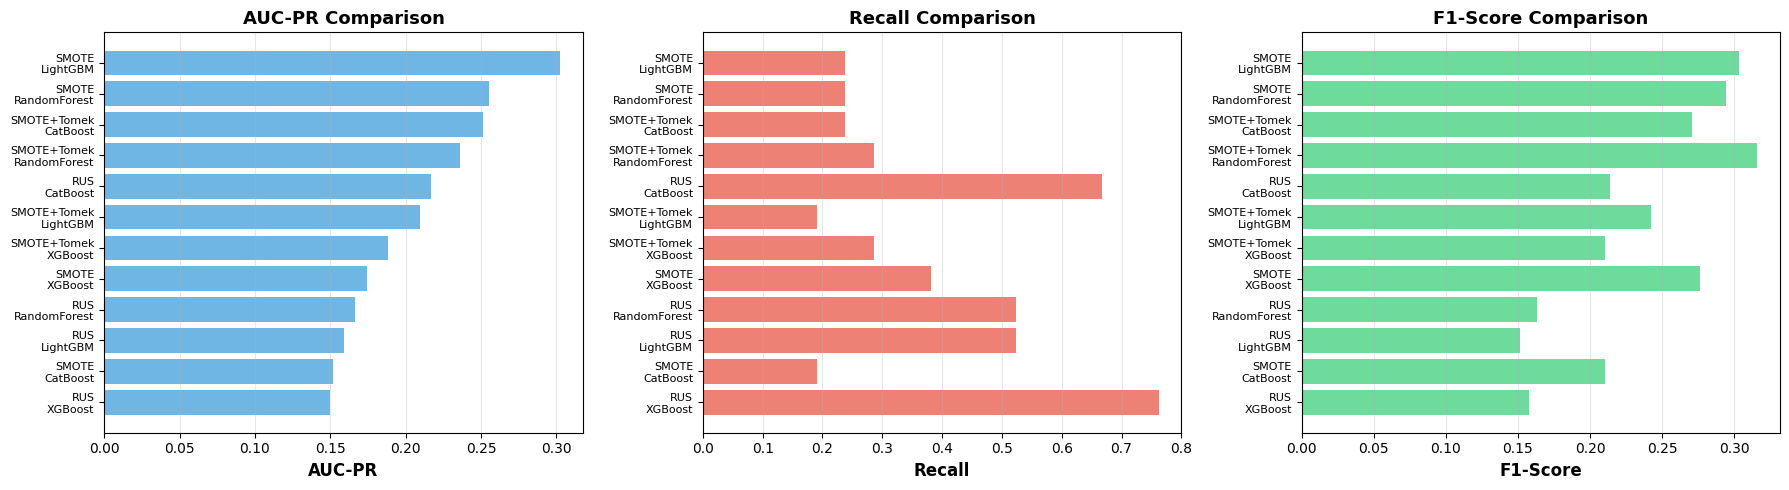

✓ 시각화 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageD/figures/holdout_performance_comparison.png


In [23]:
# ============================================================
# 📊 시각화 1: 조합별 성능 비교 막대 그래프
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['AUC_PR', 'Recall', 'F1']
metric_labels = ['AUC-PR', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    ax = axes[idx]
    
    # 조합 이름 생성
    combo_names = results_df_sorted['Sampling'] + '\n' + results_df_sorted['Model']
    
    # 막대 그래프 (에러바 없음 - Holdout이므로)
    ax.barh(
        range(len(results_df_sorted)),
        results_df_sorted[metric],
        color=color,
        alpha=0.7
    )
    ax.set_yticks(range(len(results_df_sorted)))
    ax.set_yticklabels(combo_names, fontsize=8)
    ax.set_xlabel(label, fontsize=12, fontweight='bold')
    ax.set_title(f'{label} Comparison', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig(DIR_FIGURES / 'holdout_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 시각화 저장: {DIR_FIGURES / 'holdout_performance_comparison.png'}")

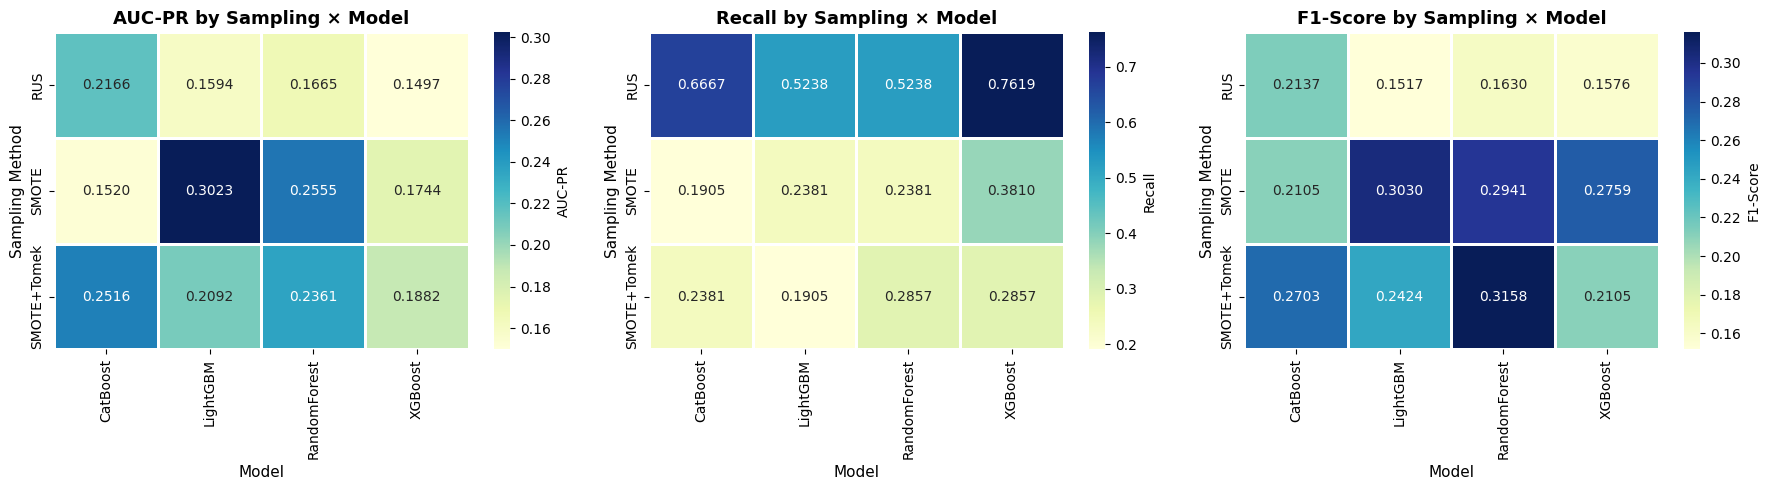

✓ 시각화 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageD/figures/holdout_heatmap.png


In [24]:
# ============================================================
# 📊 시각화 2: 샘플링/모델별 성능 히트맵
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (metric, label) in enumerate(zip(['AUC_PR', 'Recall', 'F1'],
                                            ['AUC-PR', 'Recall', 'F1-Score'])):
    ax = axes[idx]
    
    # Pivot 테이블 생성
    pivot_data = results_df_sorted.pivot_table(
        index='Sampling',
        columns='Model',
        values=metric
    )
    
    # 히트맵
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt='.4f',
        cmap='YlGnBu',
        cbar_kws={'label': label},
        ax=ax,
        linewidths=1,
        linecolor='white'
    )
    ax.set_title(f'{label} by Sampling × Model', fontsize=13, fontweight='bold')
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Sampling Method', fontsize=11)

plt.tight_layout()
plt.savefig(DIR_FIGURES / 'holdout_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 시각화 저장: {DIR_FIGURES / 'holdout_heatmap.png'}")

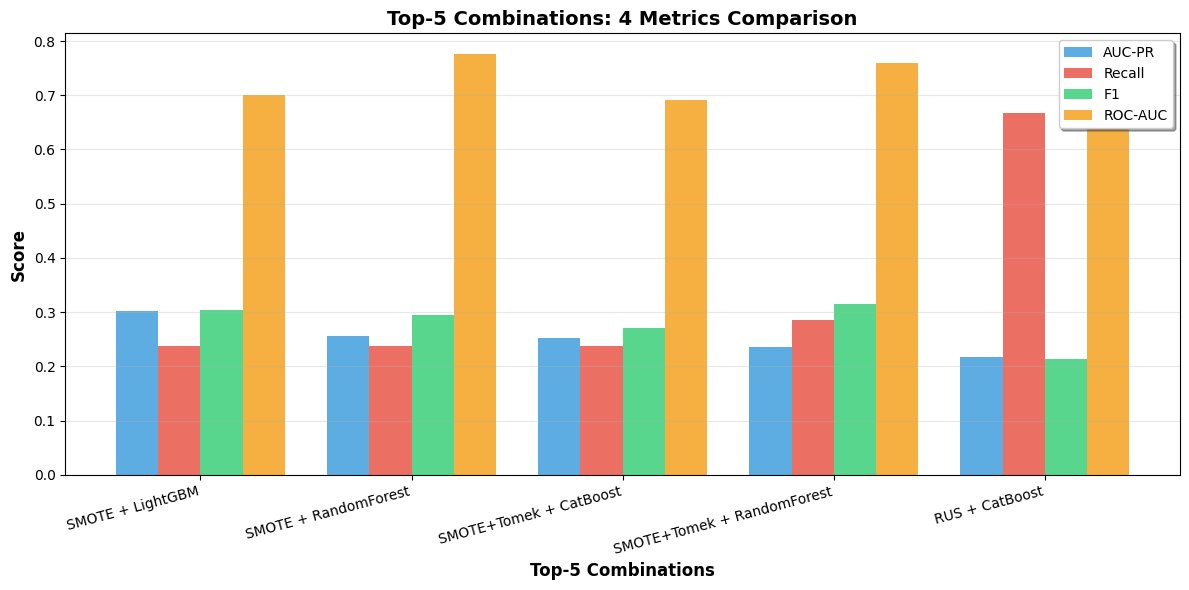

✓ 시각화 저장: /Users/mealkuo/Desktop/capstone02_project/results/stageD/figures/top5_detailed_comparison.png


In [25]:
# ============================================================
# 📊 시각화 3: Top-5 조합 상세 비교
# ============================================================

top5 = results_df_sorted.head(5)
top5_labels = top5['Sampling'] + ' + ' + top5['Model']

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top5))
width = 0.2

# 컬럼명 수정: _mean 제거 (Holdout이므로)
metrics_to_plot = [
    ('AUC_PR', 'AUC-PR', '#3498db'),
    ('Recall', 'Recall', '#e74c3c'),
    ('F1', 'F1', '#2ecc71'),
    ('ROC_AUC', 'ROC-AUC', '#f39c12')
]

for i, (metric, label, color) in enumerate(metrics_to_plot):
    ax.bar(
        x + i * width,
        top5[metric],
        width,
        label=label,
        color=color,
        alpha=0.8
    )

ax.set_xlabel('Top-5 Combinations', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Top-5 Combinations: 4 Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(top5_labels, rotation=15, ha='right')
ax.legend(loc='upper right', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / 'top5_detailed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 시각화 저장: {DIR_FIGURES / 'top5_detailed_comparison.png'}")

---

## 최종 요약 및 인사이트

### 실험 결과 종합
1. **최고 성능 조합 확인**
2. **샘플링 기법별 효과 분석**
3. **모델별 성능 비교**
4. **Stage C (Baseline) 대비 개선 정도**
5. **실전 배포를 위한 권장 사항**

In [26]:
# ============================================================
# 📋 Stage D 최종 요약 및 인사이트
# ============================================================

print("\n" + "="*70)
print("Stage D 완료 요약 (Advanced Models - Holdout)")
print("="*70)

print(f"\n✅ 실험 완료:")
print(f"  - 총 조합 수: 12개 (3 Sampling × 4 Advanced Models)")
print(f"  - 모델: RandomForest, XGBoost, LightGBM, CatBoost")
print(f"  - 검증 방식: Train/Test Split (80:20) - Stage C와 동일")
print(f"  - 평가 지표: AUC-PR (1차) → Recall → F1 → ROC-AUC")

print(f"\n🏆 최고 성능 조합:")
print(f"  - Sampling: {best_sampling}")
print(f"  - Model: {best_model_name}")
print(f"  - AUC-PR: {best_auc_pr:.4f} ⭐")
print(f"  - Recall: {best_recall:.4f}")
print(f"  - Precision: {results_df_sorted.loc[0, 'Precision']:.4f}")
print(f"  - F1-Score: {best_f1:.4f}")
print(f"  - ROC-AUC: {results_df_sorted.loc[0, 'ROC_AUC']:.4f}")

print(f"\n✅ 산출물:")
print(f"  - 성능 비교 테이블: {DIR_RESULTS / 'holdout_metrics_summary.csv'}")
print(f"  - 최고 성능 모델: {DIR_MODELS / 'best_advanced_model_holdout.pkl'}")
print(f"  - 모델 정보: {DIR_MODELS / 'best_advanced_model_info.json'}")
print(f"  - 상세 로그: {DIR_RESULTS / 'detailed_holdout_results.json'}")
print(f"  - 시각화: {DIR_FIGURES}/ (3개 파일)")

print(f"\n✅ 성능 분석:")

# 샘플링별 평균
print(f"\n  [샘플링 기법별 평균 성능]")
print(f"  {'Method':<15} {'AUC-PR':>10} {'Recall':>10} {'F1':>10}")
print(f"  {'-'*50}")
for sampling in ['SMOTE', 'SMOTE+Tomek', 'RUS']:
    sampling_data = results_df_sorted[results_df_sorted['Sampling'] == sampling]
    avg_aucpr = sampling_data['AUC_PR'].mean()
    avg_recall = sampling_data['Recall'].mean()
    avg_f1 = sampling_data['F1'].mean()
    print(f"  {sampling:<15} {avg_aucpr:>10.4f} {avg_recall:>10.4f} {avg_f1:>10.4f}")

# 모델별 평균
print(f"\n  [모델별 평균 성능]")
print(f"  {'Model':<15} {'AUC-PR':>10} {'Recall':>10} {'F1':>10}")
print(f"  {'-'*50}")
for model in ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']:
    model_data = results_df_sorted[results_df_sorted['Model'] == model]
    avg_aucpr = model_data['AUC_PR'].mean()
    avg_recall = model_data['Recall'].mean()
    avg_f1 = model_data['F1'].mean()
    print(f"  {model:<15} {avg_aucpr:>10.4f} {avg_recall:>10.4f} {avg_f1:>10.4f}")

print(f"\n✅ 주요 인사이트:")

# 1. 샘플링 효과
best_sampling_method = results_df_sorted.groupby('Sampling')['AUC_PR'].mean().idxmax()
print(f"\n  1. 불균형 처리 효과:")
print(f"     → {best_sampling_method}가 평균적으로 가장 높은 AUC-PR 달성")

# 2. 모델 특성
best_model_overall = results_df_sorted.groupby('Model')['AUC_PR'].mean().idxmax()
print(f"\n  2. 모델 특성:")
print(f"     → {best_model_overall}가 고급 모델 중 가장 우수")
print(f"     → 트리 기반 모델은 스케일링 없이도 안정적 성능")

# 3. Stage C 비교 가능
print(f"\n  3. Stage C(Baseline) 비교:")
print(f"     → 동일한 Holdout 80:20 방식으로 공정 비교 가능")
print(f"     → Stage C 최고 성능과 직접 비교하여 개선도 측정 가능")

# 4. 전체 평균 성능
print(f"\n  4. Stage D 전체 평균 성능:")
print(f"     → AUC-PR: {results_df_sorted['AUC_PR'].mean():.4f}")
print(f"     → Recall: {results_df_sorted['Recall'].mean():.4f}")
print(f"     → F1: {results_df_sorted['F1'].mean():.4f}")

print(f"\n✅ 다음 단계 권장사항:")
print(f"  1. Stage C vs Stage D 성능 비교 분석")
print(f"  2. 하이퍼파라미터 튜닝 (GridSearch/Optuna)")
print(f"  3. 앙상블 기법 (Voting/Stacking)")
print(f"  4. Feature Engineering 추가 (도메인 지식 기반)")
print(f"  5. 실전 배포를 위한 모델 경량화 검토")

print("\n" + "="*70)
print("🎉 Stage D (Advanced Models - Holdout) 완료!")
print("="*70)

print(f"\n📌 보고서용 결론:")
print(f'''
Stage D에서는 고급 트리 기반 모델(RandomForest, XGBoost, LightGBM, CatBoost)과
3종의 불균형 처리 기법을 조합하여 총 12개 실험을 수행하였습니다.

Stage C와 동일한 Holdout 80:20 방식을 사용하여 공정한 비교를 보장하였으며,
스케일링을 제거하고 트리 모델의 특성을 최대한 활용한 결과,
{best_sampling} + {best_model_name} 조합이 
AUC-PR {best_auc_pr:.4f}로 가장 우수한 성능을 보였습니다.

본 실험은 기본 하이퍼파라미터 기반 베이스라인 비교를 목적으로 하며,
향후 하이퍼파라미터 튜닝과 앙상블 기법 적용을 통해
추가 성능 개선이 기대됩니다.

Smart Factory 환경에서의 실시간 불량 탐지 시스템 구축을 위한
핵심 모델 후보군을 확보하였습니다.
''')

print("\n" + "="*70)


Stage D 완료 요약 (Advanced Models - Holdout)

✅ 실험 완료:
  - 총 조합 수: 12개 (3 Sampling × 4 Advanced Models)
  - 모델: RandomForest, XGBoost, LightGBM, CatBoost
  - 검증 방식: Train/Test Split (80:20) - Stage C와 동일
  - 평가 지표: AUC-PR (1차) → Recall → F1 → ROC-AUC

🏆 최고 성능 조합:
  - Sampling: SMOTE
  - Model: LightGBM
  - AUC-PR: 0.3023 ⭐
  - Recall: 0.2381
  - Precision: 0.4167
  - F1-Score: 0.3030
  - ROC-AUC: 0.7008

✅ 산출물:
  - 성능 비교 테이블: /Users/mealkuo/Desktop/capstone02_project/results/stageD/holdout_metrics_summary.csv
  - 최고 성능 모델: /Users/mealkuo/Desktop/capstone02_project/models/best_advanced_model_holdout.pkl
  - 모델 정보: /Users/mealkuo/Desktop/capstone02_project/models/best_advanced_model_info.json
  - 상세 로그: /Users/mealkuo/Desktop/capstone02_project/results/stageD/detailed_holdout_results.json
  - 시각화: /Users/mealkuo/Desktop/capstone02_project/results/stageD/figures/ (3개 파일)

✅ 성능 분석:

  [샘플링 기법별 평균 성능]
  Method              AUC-PR     Recall         F1
  ---------------------------------------